# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from decision_transformer.models.decision_transformer import DecisionTransformer
from decision_transformer.sum_to_one import project_portfolio_weights

/root/miniconda3/envs/decision-transformer-gym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Generation
Here we define the function for the generation of $T$-days returns of $N$ stocks from a multi-variate Gaussian distribution with the true mean return vector `mu` of shape $(N, 1)$, and the true return covariance matrix `Sigma` of shape $(N, N)$.

In [2]:
# Generate data with seed = 42, align with the evaluation data for decision transformer
def generate_returns(T, N, mu, Sigma, seed=42, num_samples=1):
    """
    Generate num_samples sets of T days of returns for N assets from a multivariate Gaussian.

    Parameters
    ----------
    T : int
        Number of time periods (e.g. 30).
    N : int
        Number of assets.
    mu : array_like, shape (N,)
        Expected returns.
    Sigma : array_like, shape (N, N)
        Covariance matrix.
    seed : int
        Random seed for reproducibility.
    num_samples : int
        Number of independent samples (paths) to generate.

    Returns
    -------
    returns : np.ndarray, shape (num_samples, T, N) if num_samples > 1, else (T, N)
        Simulated return matrix or matrices.
    """
    np.random.seed(seed)
    if num_samples == 1:
        return np.random.multivariate_normal(mu, Sigma, size=T)
    else:
        return np.array([
            np.random.multivariate_normal(mu, Sigma, size=T)
            for _ in range(num_samples)
        ])

Now, we take $N = 3$ and $T = 30$ to generate 50 sets of $30$-day returns of $3$ stocks.

In [3]:
# Define parameters
T, N = 30, 3
mu = np.array([0.001, 0.0015, 0.0012]) # Expected returns
# Covariance matrix
Sigma = np.array([
        [0.0001, 0.00002, 0.00001],
        [0.00002, 0.00015, 0.00003],
        [0.00001, 0.00003, 0.00012]
    ])

# Generate 50 independent 30-day return paths for 3 assets from a multivariate Gaussian.
all_returns = generate_returns(T, N, mu, Sigma, num_samples=50)

## Plotting the Returns

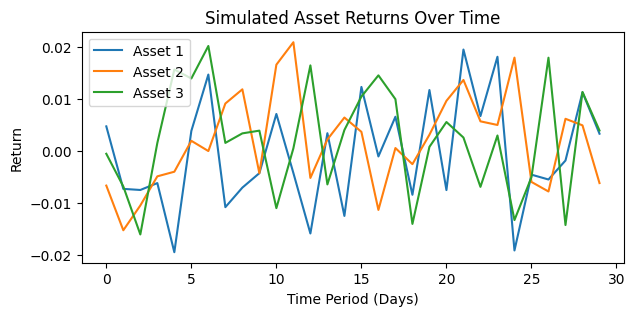

In [4]:
def plot_returns(returns, num_samples=1):
    """
    Plot the returns of N assets over T time periods.

    Parameters
    ----------
    returns : np.ndarray, shape (num_samples, T, N) or (T, N)
        Simulated return matrix or matrices.
    num_samples : int
        Number of independent samples (paths) generated (for distinguishing between multiple paths).
    """
    # Check the shape of returns and handle accordingly
    if len(returns.shape) == 2:  # Shape is (T, N), single sample
        T, N = returns.shape
        returns = np.expand_dims(returns, axis=0)  # Add dummy sample dimension
        num_samples = 1
    elif len(returns.shape) == 3:  # Shape is (num_samples, T, N), multiple samples
        num_samples, T, N = returns.shape

    plt.figure(figsize=(7, 3))

    if num_samples == 1:
        # Plot returns for each asset
        for i in range(N):
            plt.plot(range(T), returns[0, :, i], label=f'Asset {i+1}')
    else:
        # Plot returns for each sample
        for i in range(num_samples):
            for j in range(N):
                plt.plot(range(T), returns[i, :, j], label=f'Sample {i+1} - Asset {j+1}', alpha=0.6)
    
    plt.title('Simulated Asset Returns Over Time')
    plt.xlabel('Time Period (Days)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()


# Plot the generated returns
plot_returns(all_returns[0], num_samples=1)


# Mean-Variance Portfolio Optimisation

If the returns between each time step are i.i.d (independent and identically distributed), then the optimal allocation for each period should be the same across all periods. This is because, in the case of iid returns, the expected return and risk (variance) structure of the problem are identical at each time step, and the optimization solution doesn't depend on the specific period but rather on the overall distribution of returns. 

According to section 7.1.2 of Portfolio Optimization Theory and Application by Portfolio Optimization Theory and Application by Daniel P. Palomar, we have the optimal solution to one-period case to be $$w^* = \frac{1}{\lambda}\Sigma^{-1}\mu + \frac{1 - \frac{1}{\lambda}1^T\Sigma^{-1}\mu}{1^T\Sigma^{-1}1}\Sigma^{-1}1,$$ under the assumption that the weights sum up to $1$.

In [4]:
def mean_variance_portfolio(mu, Sigma, lambda_):
    """
    Calculate the optimal portfolio weights for a mean-variance portfolio optimization problem
    with multivariate Gaussian returns and a constraint that the portfolio weights sum to 1.
    
    Parameters
    ----------
    mu : array_like, shape (N,)
        Mean return vector (N assets).
    Sigma : array_like, shape (N, N)
        Covariance matrix of returns (N assets).
    lambda_ : float
        Risk aversion coefficient.
    
    Returns
    -------
    a_star : ndarray, shape (N,)
        Optimal portfolio weights for each asset.
    """
    # Calculate the optimal portfolio weights with the constraint that weights sum to 1
    ones = np.ones(len(mu))
    
    # Calculate gamma to ensure the sum of weights equals 1
    gamma = (1 - (1 / lambda_) * np.dot(ones, np.linalg.inv(Sigma).dot(mu))) / np.dot(ones, np.linalg.inv(Sigma).dot(ones))
    
    # Calculate the optimal weights
    a_star = (1 / lambda_) * np.linalg.inv(Sigma).dot(mu) + gamma * np.linalg.inv(Sigma).dot(ones)
    
    return a_star

## Short-term

Here we calculate the true theoretical optimal allocation based on the true distribution parameter.

In [5]:
lambda_ = 5.0 # Risk aversion parameter “mid‐range”
optimal_weights_true = mean_variance_portfolio(mu, Sigma, lambda_)
print("True optimal Portfolio Weights:", optimal_weights_true)

True optimal Portfolio Weights: [-0.009375  0.71875   0.290625]


In [6]:
# Function to calculate the resulting return over the 30-day period
def calculate_resulting_return(returns, weights):
    """
    Calculate the resulting return of the portfolio over the 30-day period based on fixed portfolio weights.
    
    Parameters
    ----------
    returns : ndarray, shape (30, N)
        Historical returns data (30 days, N assets).
    weights : ndarray, shape (N,)
        Portfolio weights (fixed for 30 days).
        
    Returns
    -------
    total_return : float
        Total portfolio return over the 30 days.
    """
    # Calculate the portfolio returns for each day
    portfolio_returns = np.dot(returns, weights)
    
    # Calculate the cumulative return over the 30 days
    cumulative_return = np.prod(1 + portfolio_returns) - 1  # Total return over the period
    
    return cumulative_return

Now we plot the performance of the true optimal portfolio on 50 generated samples 30-day returns.

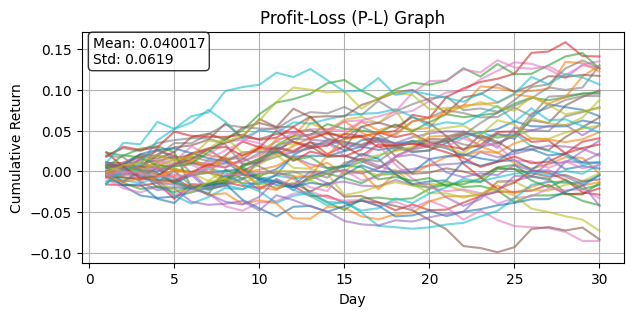

In [7]:
# Code to plot the portfolio returns and report the mean performance

perf = np.zeros(50)

plt.figure(figsize=(7, 3))

for i in range(50):
    
    # Calculate the resulting return over the 30-day period
    resulting_return = calculate_resulting_return(all_returns[i], optimal_weights_true)
    
    #print(f"Resulting Portfolio Return over 30 Days: {resulting_return:.4f}")
    
    # Calculate the portfolio returns for each day
    portfolio_returns = np.dot(all_returns[i], optimal_weights_true)
    
    # Log the portfolio returns
    perf[i] = np.prod(1 + portfolio_returns) - 1
    
    # Calculate the cumulative return over the 30 days
    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
    
    plt.plot(range(1, len(cumulative_returns) + 1), cumulative_returns, alpha=0.6)

mean_return = np.mean(perf)
std_return = np.std(perf)
plt.text(0.02, 0.98, f'Mean: {mean_return:.6f}\nStd: {std_return:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title("Profit-Loss (P-L) Graph")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

### Estimated Optimal Portforlio

Here we estimate the distribution parameters from the training trajectories used for decision transformer, i.e. using seed = 0.

Estimated optimal Portfolio Weights: [-0.85923837  1.0625427   0.79669567]


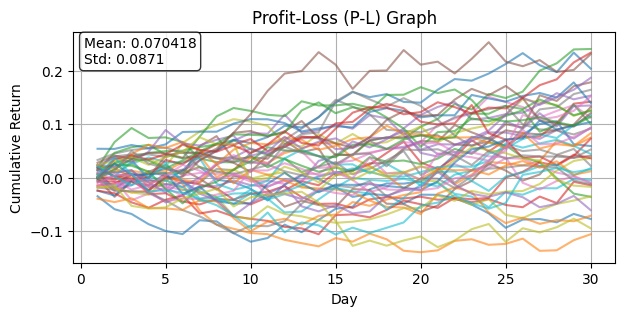

Success rate (positive returns): 74.00%


In [14]:
# Define parameters
T, N = 30, 3
mu = np.array([0.001, 0.0015, 0.0012]) # Expected returns
# Covariance matrix
Sigma = np.array([
        [0.0001, 0.00002, 0.00001],
        [0.00002, 0.00015, 0.00003],
        [0.00001, 0.00003, 0.00012]
    ])

# Generate 50 independent 30-day return paths for 3 assets from a multivariate Gaussian.
all_returns_train = generate_returns(T, N, mu, Sigma, seed = 0, num_samples=50)

# Estimated parameters
mu_hat = np.mean(all_returns_train.reshape(-1,3), axis = 0)
Sigma_hat = np.cov(all_returns_train.reshape(-1,3), rowvar=False)

lambda_ = 5.0 # Risk aversion parameter “mid‐range”
optimal_weights_hat = mean_variance_portfolio(mu_hat, Sigma_hat, lambda_)
print("Estimated optimal Portfolio Weights:", optimal_weights_hat)

# Code to plot the portfolio returns and report the mean performance

perf = np.zeros(50)

plt.figure(figsize=(7, 3))

for i in range(50):
    
    # Calculate the resulting return over the 30-day period
    resulting_return = calculate_resulting_return(all_returns_train[i], optimal_weights_hat)
    
    #print(f"Resulting Portfolio Return over 30 Days: {resulting_return:.4f}")
    
    # Calculate the portfolio returns for each day
    portfolio_returns = np.dot(all_returns_train[i], optimal_weights_hat)
    
    # Log the portfolio returns
    perf[i] = np.prod(1 + portfolio_returns) - 1
    
    # Calculate the cumulative return over the 30 days
    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
    
    plt.plot(range(1, len(cumulative_returns) + 1), cumulative_returns, alpha=0.6)

mean_return = np.mean(perf)
std_return = np.std(perf)
plt.text(0.02, 0.98, f'Mean: {mean_return:.6f}\nStd: {std_return:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title("Profit-Loss (P-L) Graph")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

print(f"Success rate (positive returns): {np.mean(np.array(perf) > 0):.2%}")

## Long-term

On the other hand, let's plot the performance of the true optimal portfolio on 50 generated samples 300-day returns.

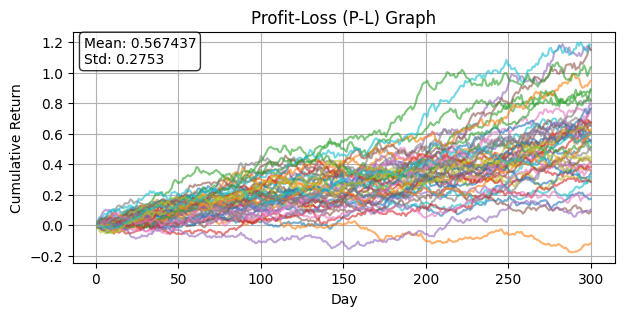

In [16]:
# Code to plot the portfolio returns and report the mean performance

# Generate 50 independent 300-day return paths for 3 assets from a multivariate Gaussian.
T = 300
all_returns_300 = generate_returns(T, N, mu, Sigma, num_samples=50)

perf = np.zeros(50)

plt.figure(figsize=(7, 3))

for i in range(50):
    
    # Calculate the resulting return over the 300-day period
    resulting_return = calculate_resulting_return(all_returns_300[i], optimal_weights_true)
    
    #print(f"Resulting Portfolio Return over 300 Days: {resulting_return:.4f}")
    
    # Calculate the portfolio returns for each day
    portfolio_returns = np.dot(all_returns_300[i], optimal_weights_true)
    
    # Log the portfolio returns
    perf[i] = np.prod(1 + portfolio_returns) - 1    
    
    # Calculate the cumulative return over the 300 days
    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
    
    plt.plot(range(1, len(cumulative_returns) + 1), cumulative_returns, alpha=0.6)

mean_return = np.mean(perf)
std_return = np.std(perf)
plt.text(0.02, 0.98, f'Mean: {mean_return:.6f}\nStd: {std_return:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title("Profit-Loss (P-L) Graph")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

### Estimated Optimal Portforlio

Estimated optimal Portfolio Weights: [-0.05193929  0.81242247  0.23951682]


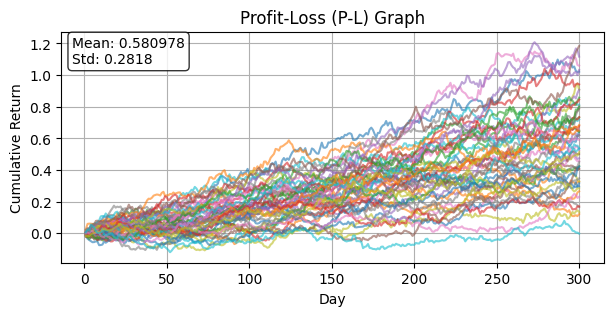

In [15]:
# Define parameters
T, N = 300, 3
mu = np.array([0.001, 0.0015, 0.0012]) # Expected returns
# Covariance matrix
Sigma = np.array([
        [0.0001, 0.00002, 0.00001],
        [0.00002, 0.00015, 0.00003],
        [0.00001, 0.00003, 0.00012]
    ])

# Generate 50 independent 300-day return paths for 3 assets from a multivariate Gaussian.
all_returns_train_300 = generate_returns(T, N, mu, Sigma, seed = 0, num_samples=50)

# Estimated parameters
mu_hat = np.mean(all_returns_train_300.reshape(-1,3), axis = 0)
Sigma_hat = np.cov(all_returns_train_300.reshape(-1,3), rowvar=False)

lambda_ = 5.0 # Risk aversion parameter “mid‐range”
optimal_weights_hat = mean_variance_portfolio(mu_hat, Sigma_hat, lambda_)
print("Estimated optimal Portfolio Weights:", optimal_weights_hat)

# Code to plot the portfolio returns and report the mean performance

perf = np.zeros(50)

plt.figure(figsize=(7, 3))

for i in range(50):
    
    # Calculate the resulting return over the 300-day period
    resulting_return = calculate_resulting_return(all_returns_train_300[i], optimal_weights_hat)
    
    #print(f"Resulting Portfolio Return over 300 Days: {resulting_return:.4f}")
    
    # Calculate the portfolio returns for each day
    portfolio_returns = np.dot(all_returns_train_300[i], optimal_weights_hat)
    
    # Log the portfolio returns
    perf[i] = np.prod(1 + portfolio_returns) - 1
    
    # Calculate the cumulative return over the 300 days
    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
    
    plt.plot(range(1, len(cumulative_returns) + 1), cumulative_returns, alpha=0.6)

mean_return = np.mean(perf)
std_return = np.std(perf)
plt.text(0.02, 0.98, f'Mean: {mean_return:.6f}\nStd: {std_return:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title("Profit-Loss (P-L) Graph")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

## Analysis

In short-term, the MVP calculated from using the true distribution parameters results in a mean return of $0.04$, with standard deviation $0.06$. On the other hand, the MVP calculated using the `mu` and `Sigma` estimated from the generated return results in a mean return of 0.0415, with standard deviation of 0.043.

This is a classic and counterintuitive phenomenon in statistical learning and finance known as: Estimation Risk Bias (or Optimism Bias). The MVP using estimated parameters is optimistically biased toward the sample data it was computed from. It overfits the sample, leading to seemingly higher expected return and possibly higher volatility. The MVP using true parameters is optimal in expectation but not tailored to the specific realization of any sample. Thus, it may appear to underperform on finite samples, even though it's the true optimizer in the population.

However, in the long-term case, the time window is 300 days. Estimates are much closer to the true parameters, and therefore the portfolio, resulting the return of the true and estimated portfolio being close to each other, due to law of large numbers reducing estimation risk.

| Metric                      | \( T = 30 \)       | \( T = 300 \)       |
|----------------------------|--------------------|---------------------|
| Estimation noise           | High               | Low                 |
| Overfitting risk           | High               | Low                 |
| \( $\hat{w} \approx w^*$ \)? | No                 | Yes                 |
| Performance gap            | Large              | Small               |

# Decision Transformer

Here, we demonstrate the performance of decision transformer. By setting the intial price (obervation) to be $[100, 120, 80]$, the training trajectories are generated based on using the same function above for mean-variance portfolio, i.e. `generate_returns`, but with a difference `seed = 0`, and then by generating random actions in the interval $(-1,1)$ we have trajectories with different returns. After training, we save the model and evaluate it on the same trajectories, i.e. `seed = 42`, with target being the theoretical mean-variance portfolio return, as in the mean-variance portfolio experiment. The below is the P-L plot for decision transformer generated portfolios.

Min portfolio return: -0.0522
Max portfolio return: 0.1122
Success rate (positive returns): 86.00%
Saved plot: pl_analysis_target_0.040.png


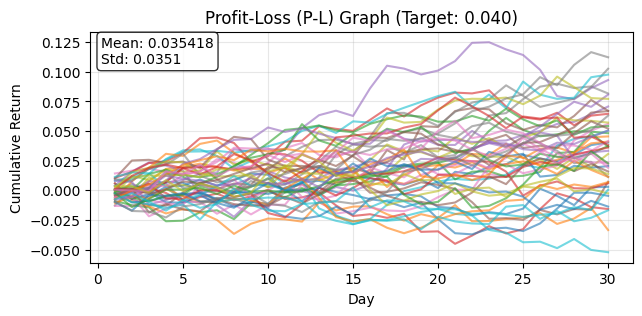

In [10]:
# Function to load the model, evaluate the trajectories using the model and plot the P-L plot for decision transformer
model_path = 'dt_model_target_0.020_0.040_0.050_0.066_scale_0.1.pth'
eval_dataset_path = 'data/simulated_stock_eval_31x50.pkl'
train_dataset_path = 'data/simulated_stock_trajs_medium.pkl'
target_return = 0.04
scale = 0.1
K = 31
embed_dim = 128
n_layer = 3
n_head = 1
device = 'cuda'

def load_model(model_path, variant):
    device = variant['device']
    model = DecisionTransformer(
        state_dim=variant['state_dim'],
        act_dim=variant['act_dim'],
        max_length=variant['K'],
        max_ep_len=variant['max_ep_len'],
        hidden_size=variant['embed_dim'],
        n_layer=variant['n_layer'],
        n_head=variant['n_head'],
        n_inner=4*variant['embed_dim'],
        activation_function=variant.get('activation_function', 'relu'),
        n_positions=1024,
        resid_pdrop=variant.get('dropout', 0.1),
        attn_pdrop=variant.get('dropout', 0.1),
    ).to(device=device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def evaluate_episode_with_model(model, eval_traj, target_return, max_ep_len, scale, state_mean, state_std, device):
    '''evaluate the evaj_traj with the saved trained model, return the generated actions and the resulting returns'''
    
    # Switches the model to evaluation mode (e.g., turns off dropout, etc)
    model.eval()
    
    # Load and normalize the evaluation data
    original_states = eval_traj['observations'].astype(np.float32)
    original_rewards = eval_traj['rewards'].astype(np.float32)
    state_dim = original_states.shape[1]
    act_dim = eval_traj['actions'].shape[1]
    normalized_states = (original_states - state_mean.astype(np.float32)) / state_std.astype(np.float32)
    
    # Initialize first state and empty tensors
    states = torch.from_numpy(normalized_states[0]).to(device=device, dtype=torch.float32).reshape(1, state_dim)
    # Creates a zero-tensor with 0 rows
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    target_return_tensor = torch.tensor(target_return / scale, device=device, dtype=torch.float32).reshape(1, 1)
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    
    # Record all actions and resulting portfolio returns.
    generated_actions = []
    portfolio_returns = []
    for t in range(len(original_states)):
        # Grow actions and rewards as we sweep through time
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device, dtype=torch.float32)], dim=0) # 0 dumy variable
        rewards = torch.cat([rewards, torch.zeros(1, device=device, dtype=torch.float32)])
        with torch.no_grad():
            # Get action from the loaded model
            action = model.get_action(
                states.to(dtype=torch.float32),
                actions.to(dtype=torch.float32),
                rewards.to(dtype=torch.float32),
                target_return_tensor.to(dtype=torch.float32),
                timesteps.to(dtype=torch.long),
            )
            action = project_portfolio_weights(action.unsqueeze(0)).squeeze(0)
            actions[-1] = action
            action_np = action.detach().cpu().numpy()
            generated_actions.append(action_np.copy())
        
        # Compute return if not last timestep
        if t < len(original_states) - 1:
            p_t = original_states[t]
            p_tp1 = original_states[t + 1]
            asset_returns = (p_tp1 - p_t) / p_t
            portfolio_return = np.dot(action_np, asset_returns)
            portfolio_returns.append(float(portfolio_return))
            rewards[-1] = torch.tensor(portfolio_return, device=device, dtype=torch.float32)
            # Update return-to-go and next state
            current_rtg = target_return_tensor[0, -1].item()
            scaled_reward = portfolio_return / scale
            pred_return = torch.tensor((1 + current_rtg) / (1 + scaled_reward) - 1, device=device, dtype=torch.float32)
            target_return_tensor = torch.cat([target_return_tensor, pred_return.reshape(1, 1)], dim=1)
            if t + 1 < len(original_states):
                next_state = torch.from_numpy(normalized_states[t + 1]).to(device=device, dtype=torch.float32).reshape(1, state_dim)
                states = torch.cat([states, next_state], dim=0)
                timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)
    return np.array(generated_actions), np.array(portfolio_returns)

def plot_profit_loss_curves(all_portfolio_returns, target_return):
    num_trajectories = len(all_portfolio_returns)
    final_returns = []
    plt.figure(figsize=(7, 3))
    # for ith value in all_portfolio_returns
    for i, portfolio_returns in enumerate(all_portfolio_returns):
        if len(portfolio_returns) > 0:
            cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
            final_return = np.prod(1 + portfolio_returns) - 1
            final_returns.append(final_return)
            days = range(1, len(cumulative_returns) + 1)
            plt.plot(days, cumulative_returns, alpha=0.6)
    plt.title(f"Profit-Loss (P-L) Graph (Target: {target_return:.3f})")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.grid(True, alpha=0.3)
    if final_returns:
        mean_return = np.mean(final_returns)
        std_return = np.std(final_returns)
        plt.text(0.02, 0.98, f'Mean: {mean_return:.6f}\nStd: {std_return:.4f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    return final_returns

if __name__ == "__main__":
    with open(train_dataset_path, 'rb') as f:
        train_trajectories = pickle.load(f)
    
    train_states = []
    for path in train_trajectories:
        train_states.append(path['observations'])
    states_concat = np.concatenate(train_states, axis=0)
    state_mean = np.mean(states_concat, axis=0)
    state_std = np.std(states_concat, axis=0) + 1e-6
    
    with open(eval_dataset_path, 'rb') as f:
        eval_trajectories = pickle.load(f)
    
    state_dim = states_concat.shape[1]
    act_dim = train_trajectories[0]['actions'].shape[1]
    max_ep_len = len(eval_trajectories[0]['observations'])
    
    variant = {
        'device': device,
        'state_dim': state_dim,
        'act_dim': act_dim,
        'max_ep_len': max_ep_len,
        'K': K,
        'embed_dim': embed_dim,
        'n_layer': n_layer,
        'n_head': n_head,
    }
    
    model = load_model(model_path, variant)
    
    all_portfolio_returns = []
    for i, traj in enumerate(eval_trajectories):
        try:
            generated_actions, portfolio_returns = evaluate_episode_with_model(
                model, traj, target_return, max_ep_len, scale, state_mean, state_std, device
            )
            all_portfolio_returns.append(portfolio_returns)
        except Exception as e:
            all_portfolio_returns.append(np.array([]))
    final_returns = plot_profit_loss_curves(all_portfolio_returns, target_return)
    
    if final_returns:
        print(f"Min portfolio return: {np.min(final_returns):.4f}")
        print(f"Max portfolio return: {np.max(final_returns):.4f}")
        print(f"Success rate (positive returns): {np.mean(np.array(final_returns) > 0):.2%}")
        print(f"Saved plot: pl_analysis_target_{target_return:.3f}.png") 

## Reproducing the Trained Decision Transformer

To train the Decision Transformer model used in the evaluation above, run the following command in the terminal:

```bash
python experiment.py --dataset_path data/simulated_stock_trajs_medium.pkl --eval_dataset_path data/simulated_stock_eval_31x50.pkl --model_type dt --max_iters 20 --num_steps_per_iter 2000 --batch_size 32 --K 31 --embed_dim 128 --n_layer 3 --n_head 1 --scale 0.1 --learning_rate 1e-4 --device cuda --env_targets 0.02 0.04 0.05 0.066
```

# Comparison Between Decision Transformer and Estimated Mean-Variance Portfolio

## Performance Summary

| Model                       | Mean Return | Std Dev (Risk) |
|----------------------------|-------------|----------------|
| **Theoretical MVP Target** | **0.040000**| —              |
| **Decision Transformer**   | 0.034192    | 0.0347         |
| **Estimated MVP**          | 0.041590    | 0.0431         |


## Comparison

### 1. Return Accuracy
- **Decision Transformer (DT)** underperforms the theoretical MVP return by:

  \[
  $0.04 - 0.034192 = 0.005808$
  \]

- **Estimated MVP** slightly overshoots the target:

  \[
  $0.041590 - 0.04 = 0.001590$
  \]

- Therefore, the estimated MVP is closer to the target return than DT in absolute terms.


### 2. Risk (Standard Deviation)
- DT has lower standard deviation $(0.0347)$ compared to estimated MVP $(0.0431)$.
- This suggests that DT may implicitly learn to reduce risk, possibly at the cost of return.


### 3. Risk-Adjusted Performance 

- **DT Sharpe ratio**:

  \[
  $\frac{0.034192}{0.0347} \approx 0.985$
  \]

- **Estimated MVP Sharpe ratio**:

  \[
  $\frac{0.041590}{0.0431} \approx 0.965$
  \]

Despite lower return, **DT has a slightly better risk-adjusted return**.

## Key Modeling Differences

- The **Mean-Variance Portfolio (MVP)** is derived under the assumption of a known Gaussian distribution and uses a closed-form solution that explicitly optimizes return and variance.
- The **Decision Transformer** operates without knowledge of the true data-generating process, and relies solely on offline trajectory data to learn a mapping from return-to-go and state to actions.


## DT's Insensitivity to Target Return

When the target return for DT was varied among:
- 0.02, 0.04, 0.05, and 0.067,

the resulting mean returns only increased marginally, remaining in the 0.035 range (see `My_DT_v2/log` lines 121-155)